In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from heapq import heappush, heappop
from itertools import count
from networkx.algorithms.community.centrality import girvan_newman

Гирван-Ньюман

In [6]:
def edge_betweenness_centrality(G,normalized=True):
    """
    Calculates the edge-betweenness-centrality score for each edge in graph G.

    Parameters
    ----------
    G : Graph input of type networkx graph object.
    normalized : Boolean True or False to normalize the betweeness score.

    Returns
    -------
    betweenness : List containing the betweenness score of all the edges
    """
    # Set betweenness of all vertices and edges as zero
    betweenness = dict.fromkeys(G, 0.0) 
    betweenness.update(dict.fromkeys(G.edges(), 0.0))

    nodes = G
    for node in nodes:
        S, parent, sigma = single_source_dijkstra(G, node)
        betweenness = get_betweenness(betweenness, S, parent, sigma, node)
    # remove nodes and keep edges
    for n in G:  
        del betweenness[n]
    betweenness = rescale_edges(betweenness, len(G), normalized=normalized, directed=G.is_directed())
    return betweenness

def single_source_dijkstra(G, node):
    """
    Performs Djikstra's shortest path algorithm to find the shortest path
    between the given node and all the other vertices in G

    Parameters
    ----------
    G : Graph input of type networkx graph object.
    node : Source node from which we find the shortest path to all the other vertices

    Returns
    -------
    S : List of nodes that were travered
    parent : List containing the parents of each node
    sigma :  List containing the number of shortest paths from node to all other vertices
    """
    S = []
    parent = {}
    for v in G:
        parent[v] = []
    sigma = dict.fromkeys(G, 0.0) 
    distance = {}
    sigma[node] = 1.0
    seen = {node: 0}
    c = count()
    Q = []
    heappush(Q, (0, next(c), node, node))
    while Q:
        (dist, _, pred, u) = heappop(Q)
        if u in distance:
            continue 
        sigma[u] += sigma[pred]
        S.append(u)
        distance[u] = dist
        for v, edgedata in G[u].items():
            uv_dist = dist + edgedata.get(None, 1)
            if v not in distance and (v not in seen or uv_dist < seen[v]):
                seen[v] = uv_dist
                heappush(Q, (uv_dist, next(c), u, v))
                sigma[v] = 0.0
                parent[v] = [u]
            elif uv_dist == seen[v]: 
                sigma[v] += sigma[u]
                parent[v].append(u)
    return S, parent, sigma


def get_betweenness(betweenness, S, parent, sigma, s):
    delta = dict.fromkeys(S, 0)
    while S:
        v = S.pop()
        coeff = (1 + delta[v]) / sigma[v]
        for u in parent[v]:
            c = sigma[u] * coeff
            if (u, v) not in betweenness:
                betweenness[(v, u)] += c
            else:
                betweenness[(u, v)] += c
            delta[u] += c
        if v != s:
            betweenness[v] += delta[v]
    return betweenness

def rescale_edges(betweenness, n, normalized, directed=False, k=None):
    if normalized:
        if n <= 1:
            scale = None
        else:
            scale = 1 / (n * (n - 1))
    else:  
        # divide by 2 for undirected graphs
        if not directed:
            scale = 0.5
        else:
            scale = None
    if scale is not None:
        if k is not None:
            scale = scale * n / k
        for u in betweenness:
            betweenness[u] *= scale
    return betweenness

In [7]:
def edge_to_remove(graph):
    ebc_per_edge = edge_betweenness_centrality(graph)
    edge = ()
    for key, value in sorted(ebc_per_edge.items(), key=lambda item: item[1], reverse = True):
        edge = key
        break
    return edge

def girvan_newman(graph, num_communities):
    """
    Perform Girvan Neuman Divisive community detection 

    Parameters 
    ----------
    graph : Graph object of type networkx
    num_communities : Number of communities that we want to detect in the graph

    Returns
    -------
    cc_node_set : List conatining sets of connected components or communities detected
    removed_edges : Edges that were removed from the graph to get the connected componnets
    """
    cc_node_set = nx.connected_components(graph)
    cc_count = nx.number_connected_components(graph)
    removed_edges = []

    while(cc_count < num_communities):
        edge = edge_to_remove(graph)
        removed_edges.append(edge)
        graph.remove_edge(edge[0], edge[1])
        cc_node_set = nx.connected_components(graph)
        cc_count = nx.number_connected_components(graph)
        
    return cc_node_set, removed_edges

def get_remaining_edges(graph, removed_edges):
    for edge in removed_edges:
        if edge in graph.edges:
            graph.remove_edge(edge[0], edge[1])
    return graph

def visualize_community_structure(num_communities, G):
    """
    Visualize the resulting communities detected in graph G with number of communities as num_communities
    """
    communities, removed_edges = girvan_newman(G,num_communities)
    G = get_remaining_edges(G, removed_edges)
    node_groups = []

    colors = ['yellow', 'green','blue','red','cyan']

    for i in communities:
        node_groups.append(list(i))

    color_map = []
    for node in G: 
        for i in range(len(node_groups)):
            if node in node_groups[i]:
                color_map.append(colors[i])  

    pos = nx.spring_layout(G, k=0.1, iterations=15, scale=10)
    nx.draw_networkx_nodes(G, pos=pos, node_color=color_map)
    nx.draw_networkx_labels(G, pos=pos)
    nx.draw_networkx_edges(G, pos=pos, edgelist=removed_edges, width=0.25, edge_color='k', style='dashed')
    nx.draw_networkx_edges(G, pos=pos, width=1,alpha=1,edge_color='k')
    plt.show()

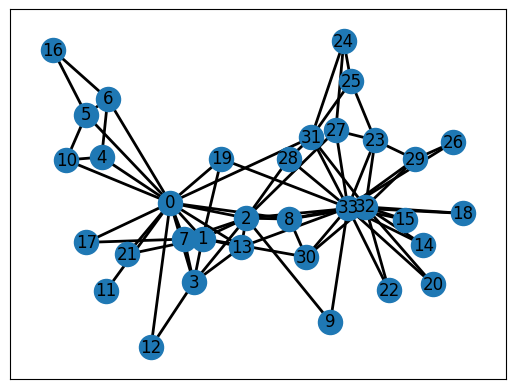

In [8]:
# Original Zachary's Karate Club graph
G = nx.karate_club_graph()
pos = nx.spring_layout(G, k=0.1, iterations=30, scale=1.3)
nx.draw_networkx_nodes(G, pos=pos)
nx.draw_networkx_labels(G, pos=pos)
nx.draw_networkx_edges(G, pos=pos, width=2,alpha=1,edge_color='k')
plt.show()

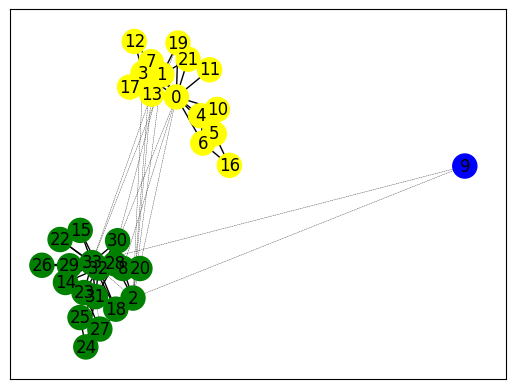

In [9]:
# Zachary's Karate Club graph with 3 communities
visualize_community_structure(num_communities=3, G = nx.karate_club_graph())

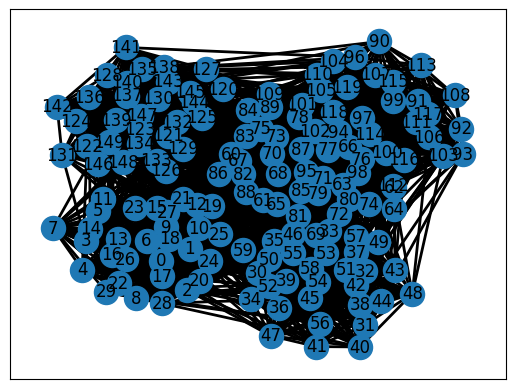

In [10]:
# Original Planted L-Partition Graph
G = nx.planted_partition_graph(5,30,0.8,0.1)
pos = nx.spring_layout(G, k=0.1, iterations=30, scale=1.3)
nx.draw_networkx_nodes(G, pos=pos)
nx.draw_networkx_labels(G, pos=pos)
nx.draw_networkx_edges(G, pos=pos, width=2,alpha=1,edge_color='k')
plt.show()

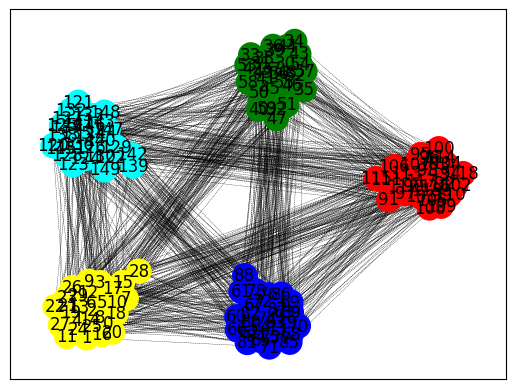

In [11]:
# Planted L-Partition Graph graph with 5 communities
visualize_community_structure(num_communities=5, G = nx.planted_partition_graph(5,30,0.8,0.1))

Алгоритм Лувина

In [13]:
def louvains_method(nodes, edges, m, k_i, w, edges_of_node, communities, actual_partition):
    best_community_list = [[n] for n in nodes]
    modularity = -1
    while True:
        community_list, communities, sigma_in, sigma_tot = modularity_optimisation(nodes, edges, communities, edges_of_node, w, k_i, m)
        new_modularity = 0
        for i in range(len(community_list)):
            new_modularity += sigma_in[i] / (m*2) - (sigma_tot[i] / (m*2) ) ** 2

        community_list = [n for n in community_list if n]

        if actual_partition:
            actual = []
            for p in community_list:
                part = []
                for node in p:
                    part.extend(actual_partition[node])
                actual.append(part)
            actual_partition = actual
            
        else:
            actual_partition = community_list
            
        if new_modularity == modularity:
            break
  
        new_nodes, new_edges, k_i, edges_of_node, w, communities = community_aggregation(nodes, edges, community_list, k_i, edges_of_node, communities, w)
        
        nodes = new_nodes
        edges = new_edges
        
        best_community_list = community_list
        modularity = new_modularity

    
    return (actual_partition, modularity)

def modularity_optimisation(nodes, edges, communities, edges_of_node, w, k_i, m):
    best_community_list = [[node] for node in nodes]
    sigma_in = [0 for node in nodes]
    sigma_tot = [k_i[node] for node in nodes]
    for edge in edges:
        if edge[0][0] == edge[0][1]:
            sigma_in[edge[0][0]] += edge[1]
            sigma_in[edge[0][1]] += edge[1]
    
    while True:
        community_check = 0
        for node in nodes:
            comm = communities[node]
            best_community = comm
            best_gain = 0

            if node not in best_community_list[comm]:
                continue

            best_community_list[comm].remove(node)
            best_weight = 0

            for e in edges_of_node[node]:
                
                if e[0][0] == e[0][1]:
                    continue
                if e[0][0] == node and communities[e[0][1]] == comm or e[0][1] == node and communities[e[0][0]] == comm:
                    best_weight += e[1]

            sigma_in[comm] -= 2 * (best_weight + w[node])
            sigma_tot[comm] -= k_i[node]
            communities[node] = -1
            lcommunities = {}
            
            neighborsu = []
            neighborsv = []
            
            for edge in edges_of_node[node]:

                if edge[0][0] == node:
                    neighborsu.append(edge[0][1])
                if edge[0][1] == node:
                    neighborsv.append(edge[0][0])
            
            neighbors = neighborsu + neighborsv

            for neighbor in neighbors:
               
                community = communities[neighbor]
                
                if community in lcommunities:
                    continue
                lcommunities[community] = 1
                
                edge_weights = 0
                for e in edges_of_node[node]:
                    if e[0][0] == e[0][1]:
                        continue
                    if e[0][0] == node and communities[e[0][1]] == community or e[0][1] == node and communities[e[0][0]] == community:
                        edge_weights += e[1]

                delta_modularity = 2 * edge_weights - sigma_tot[community] * k_i[node] / m
                
                if delta_modularity > best_gain:
                    best_community = community
                    best_gain = delta_modularity
                    best_weight = edge_weights
                    
            best_community_list[best_community].append(node)
            communities[node] = best_community
            
            sigma_in[best_community] += 2 * (best_weight + w[node])
            sigma_tot[best_community] += k_i[node]
            
            if comm != best_community:
                community_check = 1
                
        if not community_check:
            break

    return best_community_list, communities, sigma_in, sigma_tot

def community_aggregation(nodes, edges, community_list, k_i, edges_of_node, communities, w):
    new_nodes = [i for i in range(len(community_list))]
    lcommunities = []
    d = {}
    i = 0
    for comm in communities:
        if comm in d:
            lcommunities.append(d[comm])
        else:
            d[comm] = i
            lcommunities.append(i)
            i += 1
    communities = lcommunities

    n_edges = {}
    for e in edges:
        ci = communities[e[0][0]]
        cj = communities[e[0][1]]
        if (ci, cj) in n_edges:
            n_edges[(ci, cj)] += e[1]
        else:
            n_edges[(ci, cj)] = e[1]

    new_edges = [(u, v) for u, v in n_edges.items()]

    k_i = [0 for n in new_nodes]
    edges_of_node = {}
    w = [0 for n in new_nodes]
    for e in new_edges:
        k_i[e[0][0]] += e[1]
        k_i[e[0][1]] += e[1]
        if e[0][0] == e[0][1]:
            w[e[0][0]] += e[1]
        if e[0][0] not in edges_of_node:
            edges_of_node[e[0][0]] = [e]
        else:
            edges_of_node[e[0][0]].append(e)
        if e[0][1] not in edges_of_node:
            edges_of_node[e[0][1]] = [e]
        elif e[0][0] != e[0][1]:
            edges_of_node[e[0][1]].append(e)
    
    communities = [n for n in new_nodes]
    return (new_nodes, new_edges, k_i, edges_of_node, w, communities)

def calc_wts(nodes, edges):
    m = 0
    k_i = [0 for n in nodes]
    for e in edges:
            m += e[1]
            k_i[e[0][0]] += e[1]
            k_i[e[0][1]] += e[1] # there's no self-loop initially
    return m, k_i

def get_edges_of_node(edges):
    edges_of_node = {}
    for e in edges:
        if e[0][0] not in edges_of_node:
            edges_of_node[e[0][0]] = [e]
        else:
            edges_of_node[e[0][0]].append(e)
        if e[0][1] not in edges_of_node:
            edges_of_node[e[0][1]] = [e]
        elif e[0][0] != e[0][1]:
            edges_of_node[e[0][1]].append(e)
    return edges_of_node

def add_weight_to_edge(edges):
    edge_list = []
    unit_weight = 1
    for e in edges:
        edge_list.append(((e[0], e[1]), unit_weight))
    return edge_list

In [14]:
def visualize_graph(G, pos, labels_dict=None, colors=None, node_size=100, edge_alpha=0.1, labels=False):
    """
    Visualizes graph with clusters as different colors
    """

    if labels_dict is not None and colors is not None:
        for k, v in labels_dict.items():
            # nodes
            nx.draw_networkx_nodes(G, 
                pos,
                nodelist=v,
                node_color=colors[k],
                node_size=node_size
            )
    else:
        nx.draw_networkx_nodes(G, pos, node_size=node_size) 
        
    if labels:
        nx.draw_networkx_labels(G, pos)

    nx.draw_networkx_edges(G, pos, width=1.0, alpha=edge_alpha)

In [16]:
def zachary():
    
    G = nx.karate_club_graph()
    initial_vertices = list(G.nodes)
    initial_edges = add_weight_to_edge(list(G.edges))

    m, k_i = calc_wts(initial_vertices, initial_edges)
    w = [0 for n in initial_vertices]
    communities = [n for n in initial_vertices]
    edges_of_node = get_edges_of_node(initial_edges)
    full_community_list = []

    return G, louvains_method(initial_vertices, initial_edges, m, k_i, w, edges_of_node, communities, full_community_list)
    
def plantedl():
    G = nx.planted_partition_graph(5, 100, 0.5, 0.1, seed=42)
#     G = nx.planted_partition_graph(5, 200, 0.8, 0.1, seed=42)
#     G = nx.planted_partition_graph(2, 200, 0.6, 0.3, seed=42)
    initial_vertices = list(G.nodes)
    initial_edges = add_weight_to_edge(list(G.edges))

    m, k_i = calc_wts(initial_vertices, initial_edges)
    w = [0 for n in initial_vertices]
    communities = [n for n in initial_vertices]
    edges_of_node = get_edges_of_node(initial_edges)
    full_community_list = []

    return G, louvains_method(initial_vertices, initial_edges, m, k_i, w, edges_of_node, communities, full_community_list)

In [17]:
result = zachary()
# print(result)
G = result[0]
final_partition = result[1][0]

final_modularity = result[1][1]
# print(final_modularity)

pos = nx.spring_layout(G)

labels_dict = {i: final_partition[i] for i in range(len(final_partition))}
print(labels_dict.keys())

COLORS = \
    ["tab:blue", "tab:orange", "tab:green", 
     "tab:red", "tab:purple", "tab:brown", 
     "tab:pink", "tab:gray", "tab:olive", 
     "tab:cyan"]

dict_keys([0, 1, 2, 3])


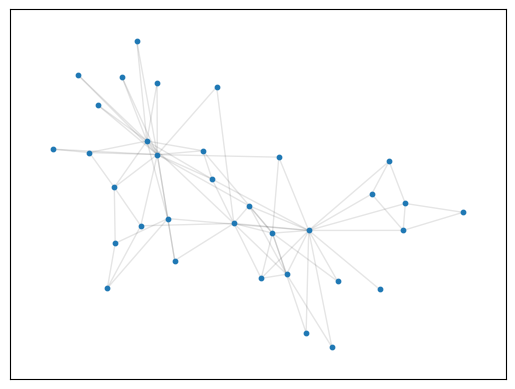

In [18]:
visualize_graph(G, pos, labels_dict=None, colors=COLORS, node_size=10)

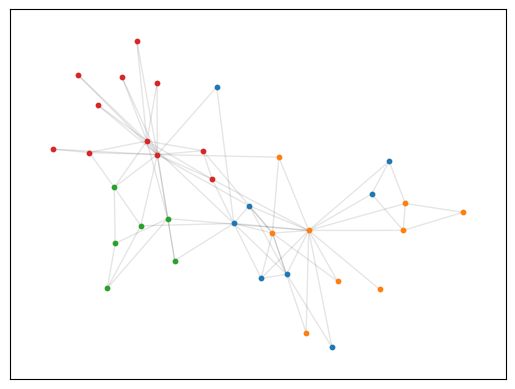

In [19]:
visualize_graph(G, pos, labels_dict=labels_dict, colors=COLORS, node_size=10)